In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Flatten, BatchNormalization, GaussianDropout, Dropout,  Activation, Lambda
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects

In [4]:
dataset_DIR = '/dataset'

In [6]:
class_Dict = {'one':0, 'two':1, 'three':2, 'four':3, 'five':4, 'ok':5, 'rock':6, 'thumbs_up':7}
inv_class_Dict = {0:'one', 1:'two', 2:'three', 3:'four', 4:'five', 5:'ok', 6:'rock', 7:'thumbs_up'}

In [7]:
X = []
Y = []

files = os.listdir(dataset_DIR)
for f in files:
  if f[-4:] == '.csv':
    data = pd.read_csv(f, header = None)
    for row in range(data.shape[0]):
      temp = []
      for pt in data.iloc[row]:
        #remove extra white spaces in the middle
        temp_pt = " ".join(pt.split()) 
        #remove brackets
        temp_pt = (temp_pt.strip(']')).strip('[')
        #remove trailing and leading white spaces
        temp_pt = temp_pt.strip()
        temp.append(float(temp_pt.split(' ')[0]))
        temp.append(float(temp_pt.split(' ')[1]))
      X.append(temp)
      Y.append(class_Dict[f[8:-4]])

In [ ]:
## Augment data

print('Number of train samples before augmentation', len(X))

# Translation
for i in range(len(X)):
    for j in range(20):
        x_offset = np.random.randint(640) - 320
        y_offset = np.random.randint(480) - 240
        offset = [x_offset, y_offset] * 21
        X.append([a + b for a, b in zip(X[i], offset)])
        Y.append(Y[i])
        
# Create new samples with keypoint(joint) coordinate noise
for i in range(len(X)):
    for j in range(20):
        offset = [0] * 42
        index = np.random.randint(420)
        if index < 42:
            offset[index] = np.random.randint(20) - 10
            
        X.append([a + b for a, b in zip(X[i], offset)])
        Y.append(Y[i])
        
print('Number of train samples after augmentation', len(X))

Number of train samples before augmentation 3922
Number of train samples after augmentation 1729602


In [ ]:
X = np.array(X)
Y = np.array(Y)

In [ ]:
X.max() 

945.56595248

In [ ]:
# Normalization
# Only rough normalization, keypoint max could be bigger than image shape along x axis because of augmentation
X = (X / X.max()) - 0.5

In [ ]:
# represent targets as one-hot-encoded 
Y_onehot = to_categorical(Y, num_classes=8)

In [ ]:
# Shuffle samples 
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

x_train, y_train = unison_shuffled_copies(X, Y_onehot)

In [ ]:
# Best combination was relu/adam
activation = 'relu' # relu / tfa.activations.mish
drop_rate = 0.5

x1 = Input(shape=(42,))

x2 = Dense(168, activation=activation) (x1) 
x2 = Dropout(drop_rate) (x2)

x3 = Dense(546, activation=activation) (x2)
x3 = Dropout(drop_rate) (x3)

x4 = Dense(8, activation='softmax') (x3)

model = Model(inputs=x1, outputs=x4)

radam = tfa.optimizers.RectifiedAdam()
ranger = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)
model.compile(loss = "categorical_crossentropy", optimizer='adam', metrics=["acc"])

model.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 42)]              0         
_________________________________________________________________
dense_31 (Dense)             (None, 168)               7224      
_________________________________________________________________
dropout_21 (Dropout)         (None, 168)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 546)               92274     
_________________________________________________________________
dropout_22 (Dropout)         (None, 546)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 8)                 4376      
Total params: 103,874
Trainable params: 103,874
Non-trainable params: 0
____________________________________________________

In [ ]:
# Train
checkpoint = ModelCheckpoint('models/model1.h5',
                             monitor='val_acc',
                             verbose=1, 
                             save_best_only=True,
                             save_weights_only=False,
                             mode='max')
history = model.fit(x_train, y_train, batch_size=256, epochs=14, validation_split=0.2, verbose=1, callbacks=[checkpoint])

Epoch 1/14
5406/5406 [==============================] - 18s 3ms/step - loss: 0.3546 - acc: 0.8896 - val_loss: 0.0388 - val_acc: 0.9876

Epoch 00001: val_acc improved from -inf to 0.98756, saving model to models/model1.h5
Epoch 2/14
5406/5406 [==============================] - 18s 3ms/step - loss: 0.0674 - acc: 0.9791 - val_loss: 0.0250 - val_acc: 0.9917

Epoch 00002: val_acc improved from 0.98756 to 0.99170, saving model to models/model1.h5
Epoch 3/14
5406/5406 [==============================] - 17s 3ms/step - loss: 0.0534 - acc: 0.9827 - val_loss: 0.0183 - val_acc: 0.9940

Epoch 00003: val_acc improved from 0.99170 to 0.99399, saving model to models/model1.h5
Epoch 4/14
5406/5406 [==============================] - 17s 3ms/step - loss: 0.0483 - acc: 0.9840 - val_loss: 0.0121 - val_acc: 0.9953

Epoch 00004: val_acc improved from 0.99399 to 0.99527, saving model to models/model1.h5
Epoch 5/14
5406/5406 [==============================] - 17s 3ms/step - loss: 0.0410 - acc: 0.9862 - val_los

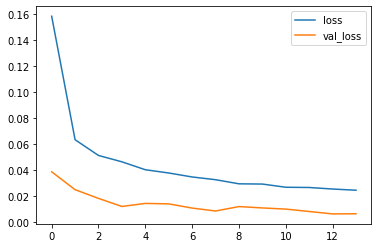

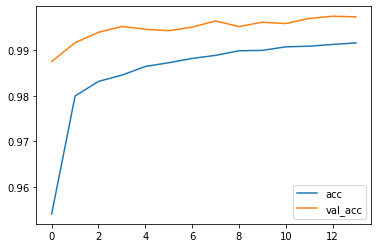

In [ ]:
# Save data
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()

In [ ]:
#Create test data
X_test = []
Y_target = []
files = os.listdir(dataset_DIR)
for f in files:
  if f[-4:] == '.csv':
    data = pd.read_csv(f, header = None)
    test = [100, 150, 200, 250]
    for row in test:
      temp = []
      for pt in data.iloc[row]:
        #remove extra white spaces in the middle
        temp_pt = " ".join(pt.split()) 
        #remove brackets
        temp_pt = (temp_pt.strip(']')).strip('[')
        #remove trailing and leading white spaces
        temp_pt = temp_pt.strip()
        temp.append(float(temp_pt.split(' ')[0]))
        temp.append(float(temp_pt.split(' ')[1]))
      X_test.append(temp)
      Y_target.append(f[8:-4])

In [ ]:
X_test = np.array(X_test)

In [ ]:
X_train_max = 945.56595248

In [ ]:
# Normalization
# Only rough normalization, keypoint max could be bigger than image shape along x axis because of augmentation
X_test = (X_test / X_train_max) - 0.5

In [ ]:
loaded_model = load_model('models/model1.h5')
Y_pred = loaded_model.predict(X_test)

In [ ]:
# decode Y_pred
Y_pred_decoded = []
for i in range(Y_pred.shape[0]):
  Y_pred_decoded.append(inv_class_Dict[np.argmax(Y_pred[i])])

print('### Predicted ###')
print(Y_pred_decoded)
print('### Ground Truth ###')
print(Y_target)

### Predicted ###
['five', 'five', 'five', 'five', 'ok', 'ok', 'ok', 'ok', 'two', 'two', 'two', 'two', 'three', 'three', 'three', 'three', 'one', 'one', 'one', 'one', 'four', 'four', 'four', 'four', 'thumbs_up', 'thumbs_up', 'thumbs_up', 'thumbs_up', 'rock', 'rock', 'rock', 'rock']
### Ground Truth ###
['five', 'five', 'five', 'five', 'ok', 'ok', 'ok', 'ok', 'two', 'two', 'two', 'two', 'three', 'three', 'three', 'three', 'one', 'one', 'one', 'one', 'four', 'four', 'four', 'four', 'thumbs_up', 'thumbs_up', 'thumbs_up', 'thumbs_up', 'rock', 'rock', 'rock', 'rock']
